In [107]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [108]:
input_pos = input("Enter Position: ")
input_deg = input("Enter Angle: ")

### Laden der Daten anhand der gegebenen Position und Messwinkel

In [109]:
def find_matching_files(file_list, angle, position):
    for file in file_list:
        if f"angle_{angle}" in file and f"pos_{position}" in file:
            matching_file = os.path.join(folder_path, file)
    return matching_file


folder_path = os.path.join(os.getcwd(), 'Logs')
files = os.listdir(folder_path)

scan_df = pd.read_csv(find_matching_files(files, input_deg, input_pos))
data_df = scan_df.iloc[:, :-3]

In [110]:
data_df

,0.0,11.25,22.5,33.75,45.0,56.25,67.5,78.75,90.0,101.25,...,258.75,270.0,281.25,292.5,303.75,315.0,326.25,337.5,348.75,shape
0,145,145,145,145,145,145,145,145,148,148,...,145,141,141,141,141,141,141,141,141,cylinder
1,141,145,145,145,145,145,145,145,148,148,...,145,141,141,142,141,141,141,141,141,cylinder
2,141,145,145,145,145,145,145,145,145,149,...,145,141,141,141,141,141,141,141,141,cylinder
3,145,145,145,145,145,145,145,149,148,148,...,145,141,141,141,141,141,141,141,141,cylinder
4,145,145,145,145,145,145,145,145,148,148,...,145,141,141,141,141,141,141,141,141,cylinder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,148,148,152,134,134,134,134,134,134,134,...,141,141,141,141,141,141,145,145,145,cylinder
1288,148,148,152,134,134,134,134,134,134,134,...,141,141,141,141,141,141,145,145,145,cylinder
1289,148,148,152,134,134,134,134,134,134,134,...,141,141,141,141,141,141,145,145,145,cylinder
1290,148,148,152,134,134,134,134,134,134,134,...,141,141,141,141,141,141,145,145,145,cylinder


### Helferfunktion, die den String-Header in einen Numpy-Array mit float-Werten umwandelt


In [111]:
def header_to_int(df: pd.DataFrame):
    columns = df.iloc[:, :-1].columns.values
    columns_int = np.array([float(column) for column in columns])
    return columns_int

### Helferfunktion, die anhand der Messwerte des Zylinders, der indirekt als Kalibrierungsobjekt dient, den Abstand eines jeden Messpunktes zum Mittelpunkt der Messplatte berechnet

In [112]:
def get_dist_middlepoint(df: pd.DataFrame):
    diameter_cylinder = 50
    grouped = df.groupby('shape').mean()
    distance_to_middle = grouped.loc['cylinder', :].values.mean() + diameter_cylinder/2
    distance_object_middle_to_edge = distance_to_middle - grouped.loc['cylinder', :].values

    return distance_object_middle_to_edge

dist = get_dist_middlepoint(data_df)   

### Helferfunktion, die den maximal möglichen Messwert berechnet

In [113]:
def get_max_possible_dist(df: pd.DataFrame):
    diameter_cylinder = 50
    cylinder_measurement = df.groupby('shape').mean().loc['cylinder', :].values.mean()

    return diameter_cylinder/2 + cylinder_measurement

max_dist = get_max_possible_dist(data_df)

In [114]:
max_dist

165.50488053613054

## Bereinigen der Messdaten
Das Bereinigen der Messdaten beginnt mit dem Ersetzen aller Werte, die den Maximalwert überschreiten mit NaN

In [115]:
angles = np.array([float(angle) for angle in data_df.columns[:-1]])

target_angles = np.linspace(0, 360, 512, endpoint=False)

df_interpolated = pd.DataFrame()

for index, row in data_df.iterrows():
    values = row[:-1].values
    
    interpolation_function = interp1d(angles, values, kind='linear', fill_value="extrapolate")
    
    interpolated_values = interpolation_function(target_angles)
    
    df_interpolated = pd.concat([df_interpolated, pd.DataFrame(interpolated_values).T], axis=0, ignore_index=True)
    #df_interpolated.append(pd.Series(interpolated_values), ignore_index=True)

df_interpolated['shape'] = data_df['shape']

new_columns = [f"{angle:.3f}" for angle in target_angles] + ['shape']
df_interpolated.columns = new_columns


In [116]:
df_interpolated

,0.000,0.703,1.406,2.109,2.812,3.516,4.219,4.922,5.625,6.328,...,353.672,354.375,355.078,355.781,356.484,357.188,357.891,358.594,359.297,shape
0,145.0,145.00,145.0,145.00,145.0,145.00,145.0,145.00,145.0,145.00,...,141.0,141.0,141.0,141.0,141.0,141.0,141.0,141.0,141.0,cylinder
1,141.0,141.25,141.5,141.75,142.0,142.25,142.5,142.75,143.0,143.25,...,141.0,141.0,141.0,141.0,141.0,141.0,141.0,141.0,141.0,cylinder
2,141.0,141.25,141.5,141.75,142.0,142.25,142.5,142.75,143.0,143.25,...,141.0,141.0,141.0,141.0,141.0,141.0,141.0,141.0,141.0,cylinder
3,145.0,145.00,145.0,145.00,145.0,145.00,145.0,145.00,145.0,145.00,...,141.0,141.0,141.0,141.0,141.0,141.0,141.0,141.0,141.0,cylinder
4,145.0,145.00,145.0,145.00,145.0,145.00,145.0,145.00,145.0,145.00,...,141.0,141.0,141.0,141.0,141.0,141.0,141.0,141.0,141.0,cylinder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,148.0,148.00,148.0,148.00,148.0,148.00,148.0,148.00,148.0,148.00,...,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,cylinder
1288,148.0,148.00,148.0,148.00,148.0,148.00,148.0,148.00,148.0,148.00,...,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,cylinder
1289,148.0,148.00,148.0,148.00,148.0,148.00,148.0,148.00,148.0,148.00,...,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,cylinder
1290,148.0,148.00,148.0,148.00,148.0,148.00,148.0,148.00,148.0,148.00,...,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,cylinder


In [117]:
# for column in df_interpolated.columns:
#     if column != 'shape':
#         df_interpolated[column] = df_interpolated[column].apply(lambda x: x if x <= max_dist else np.nan)


In [118]:
# df_interpolated[df_interpolated['shape'] == 'cube'].iloc[20,:-1].plot()

## Plot der Ergebnisse in einem Polarplot

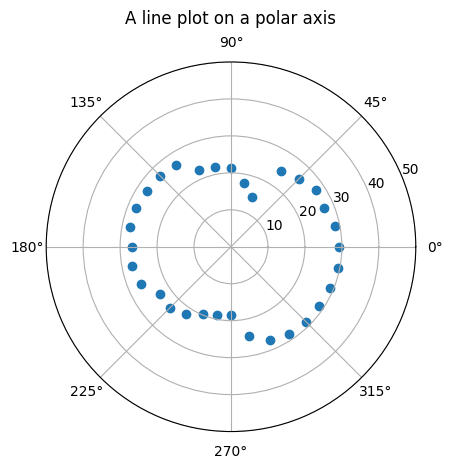

In [119]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(header_to_int(data_df)*np.pi / 180, dist)
ax.set_rmax(50)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()